In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
df = pd.read_csv("tweets2009-06-0115.csv.zip", sep='\t', compression='zip')

## Q1. Choose a hash-tag

In [3]:
allTweets = df["tweet"].str.cat(sep=' ')
tweetWords = [word.strip(""" ,.:'\";""").lower() for word in allTweets.split()]
hashTags = [word for word in tweetWords if word.startswith("#")]
hashTagsCounter = Counter(hashTags)
hashTagsCounter.most_common()[40:50]

[('#phish', 1001),
 ('#mlb', 962),
 ('#travel', 932),
 ('#bonnaroo', 887),
 ('#twitpocalypse', 879),
 ('#iranelections', 857),
 ('#rt', 856),
 ('#zensursula', 811),
 ('#jamlegend', 790),
 ('#quotes', 756)]

In [4]:
phishTag = df[df["tweet"].str.lower().str.contains("#phish", na=False)].copy()

In [5]:
phishTag.head()

,date,user,tweet
73237,2009-06-11 18:51:28,tenacioustij,"RT @ValerieELong Riverbend ""Mystery Performer""..."
180029,2009-06-11 21:52:27,inspecie,Symantec June #Spam and #Phishing Reports. Twi...
186679,2009-06-11 21:59:10,phishbucket,Job Scam Victims: go to Identity Theft Resourc...
189216,2009-06-11 22:02:13,jebrinklog,#phish DOG LOG!!!! You lucky mofos! Thanks for...
192997,2009-06-11 22:06:14,jebrinklog,#phish I have 4 Darien Lake reserved tickets t...


## Q2. Build a Mention Graph

In [6]:
def addMentionedColumn(df):
    
    def mentionsList(txt):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in txt.split()]
        allNames = [word.strip("@") for word in allWords if word.startswith("@")]
        uniqueNames = list(set(allNames))
        return allNames
    
    df["mentioned"] = df["tweet"].apply(mentionsList)
    
def mentionGraph(df):
    g = nx.Graph()
    
    for (index, date, user, tweet, mentionedUsers) in df.itertuples():
        for mentionedUser in mentionedUsers:
            if (user in g) and (mentionedUser in g[user]) and (len(mentionedUser)!=0):
                g[user][mentionedUser]["numberMentions"] += 1
            elif (len(mentionedUser)!=0):
                g.add_edge(user, mentionedUser, {'numberMentions': 1})
    
    return g

In [7]:
addMentionedColumn(phishTag)

In [8]:
phishTag.head()

,date,user,tweet,mentioned
73237,2009-06-11 18:51:28,tenacioustij,"RT @ValerieELong Riverbend ""Mystery Performer""...",[valerieelong]
180029,2009-06-11 21:52:27,inspecie,Symantec June #Spam and #Phishing Reports. Twi...,[]
186679,2009-06-11 21:59:10,phishbucket,Job Scam Victims: go to Identity Theft Resourc...,[]
189216,2009-06-11 22:02:13,jebrinklog,#phish DOG LOG!!!! You lucky mofos! Thanks for...,[]
192997,2009-06-11 22:06:14,jebrinklog,#phish I have 4 Darien Lake reserved tickets t...,[]


### (a)

In [9]:
phishGraph = mentionGraph(phishTag)
print("# nodes:", len(phishGraph.nodes()))
print("# edges:", len(phishGraph.edges()))

# nodes: 159
# edges: 126


### (b)

In [10]:
list_de = np.array(list(nx.degree(phishGraph).values()))

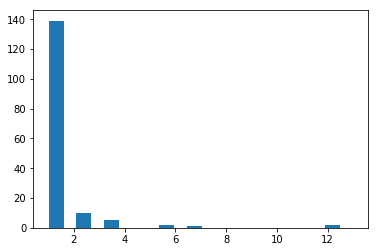

In [11]:
plt.hist(list_de, bins=11, width=0.6)
plt.show()

### (c)

In [12]:
phish_edges = phishGraph.edges(data='numberMentions') 
phish_edges.sort(key=lambda x: x[2], reverse=True)
phish_edges[:5]

[('yemblog', 'radiobonnaroo', 6),
 ('athletehabits', 'jmarskell', 3),
 ('beam_ad', 'phish', 2),
 ('beam_ad', 'rachelondeck', 2),
 ('the700level', 'onearmbird', 2)]

### (d) visualization of mention graph

In [13]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True)

In [14]:
import random
def addRandomPositions(graph):
    posDict = dict((node,(random.gauss(0,10),random.gauss(0,10))) for node in graph.nodes())
    nx.set_node_attributes(graph,"pos", posDict)

In [15]:
addRandomPositions(phishGraph)

In [16]:
import colorlover as cl
from IPython.display import HTML
#HTML(cl.to_html( cl.scales['6'] ))
purd = cl.scales['6']['seq']['YlGnBu']
purd49 = cl.interp(purd, 49)
HTML(cl.to_html(purd49))

In [17]:
def plotNetworkSizeColor(graph):
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.node[node1]['pos']
        x1, y1 = graph.node[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        edgecolor = int(48*(edgeWidth+0.5)/(6.0+0.5))
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=Line(width=edgeWidth*2, color=purd49[edgecolor]))
        scatters.append(s)



    for node in graph.nodes():
        xPos, yPos = graph.node[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                hoverinfo='none',
                mode='marker', 
                marker=dict(
                    color=purd49[30], 
                    size=10,         
                    line=dict(width=1)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)
    
def applyLayout(graph, layoutFunc):
    posDict = layoutFunc(graph) 
    nx.set_node_attributes(graph, "pos", posDict)

In [18]:
phishGraphRandom = phishGraph.copy()
applyLayout(phishGraphRandom, nx.random_layout)
plotNetworkSizeColor(phishGraphRandom)

## Q3. Content Analysis

### (a)

In [19]:
from collections import Counter
import re
from nltk.corpus import stopwords
listw = []
stop = set(stopwords.words('english'))
stop.update(('rt', 'gt', 'hey', 'im'))
for index, row in phishTag.iterrows():
    words = str(row['tweet']).split()
    words = [re.sub('[^a-zA-Z]+', '', w.lower()) for w in words]
    listw.append(words)
text = [item for sublist in listw for item in sublist if (len(item)!=0) and (item not in stop)]
word_count = Counter(text)

In [20]:
word_count.most_common(15)

[('phish', 1048),
 ('live', 845),
 ('phishtube', 822),
 ('httpustreamjr', 814),
 ('broadcast', 812),
 ('bonnaroo', 80),
 ('stream', 39),
 ('like', 35),
 ('show', 34),
 ('set', 31),
 ('time', 27),
 ('one', 22),
 ('go', 21),
 ('free', 20),
 ('get', 20)]

### (b)

In [21]:
def commonwords(user):
    df = phishTag.loc[phishTag['user'] == user]
    listw = []
    stop = set(stopwords.words('english'))
    stop.update(('rt', 'gt', 'hey', 'im'))
    for index, row in df.iterrows():
        words = str(row['tweet']).split()
        words = [re.sub('[^a-zA-Z]+', '', w.lower()) for w in words]
        listw.append(words)
    text = [item for sublist in listw for item in sublist if (len(item)!=0) and (item not in stop)]
    if len(text)>0:
        word_count = Counter(text)
        commonwords = word_count.most_common(3)
        if commonwords[0][1]<2:
            text='no word with frequency>1'
        elif commonwords[0][1]>1:
            text='Words: {}, {}, {}'.format(commonwords[0][0], commonwords[1][0], commonwords[2][0])
    else: 
        text='no word with frequency>1'
    return text

In [22]:
def plotcommonWord(graph):
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.node[node1]['pos']
        x1, y1 = graph.node[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=Line(width=edgeWidth*2, color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        xPos, yPos = graph.node[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text=commonwords(node),
                hoverinfo='text',
                mode='marker', 
                marker=dict(
                    color=purd49[30], 
                    size=10,         
                    line=dict(width=1)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [23]:
plotcommonWord(phishGraphRandom)

## Q4. Centrality Analysis

### (a)

In [24]:
degCentr = nx.degree_centrality(phishGraph)
cloCentr = nx.closeness_centrality(phishGraph)
betCentr = nx.betweenness_centrality(phishGraph)
eigCentr = nx.eigenvector_centrality(phishGraph)

### (b)

In [25]:
def plotdegCentr(graph):
    maxCentr = max(degCentr.values())
    minCentr = min(degCentr.values())
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.node[node1]['pos']
        x1, y1 = graph.node[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        nodeCentr = degCentr[node]
        nodeColor = int(48*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.node[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s\nDegree: %.3f" % (node, nodeCentr),
                hoverinfo='text',
                mode='marker', 
                marker=dict(
                    color=purd49[nodeColor], 
                    size=nodeCentr*300,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [26]:
plotdegCentr(phishGraphRandom)

In [27]:
def ploteigCentr(graph):
    maxCentr = max(eigCentr.values())
    minCentr = min(eigCentr.values())
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.node[node1]['pos']
        x1, y1 = graph.node[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        nodeCentr = eigCentr[node]
        nodeColor = int(48*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.node[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s\nCloseness: %.3f" % (node, nodeCentr),
                hoverinfo='text',
                mode='marker', 
                marker=dict(
                    color=purd49[nodeColor], 
                    size=nodeCentr*100,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [28]:
ploteigCentr(phishGraphRandom)

### (c)

In [29]:
degCentr_count = Counter(degCentr)
cloCentr_count = Counter(cloCentr)
betCentr_count = Counter(betCentr)
eigCentr_count = Counter(eigCentr)

In [30]:
degCentr_count.most_common(5)

[('beautyshow', 0.08227848101265822),
 ('tmwsiy', 0.08227848101265822),
 ('moviequotesquiz', 0.04430379746835443),
 ('bafcats', 0.0379746835443038),
 ('tenacioustij', 0.0379746835443038)]

In [31]:
cloCentr_count.most_common(6)

[('tmwsiy', 0.11747723739729068),
 ('ericwyman', 0.10223209971977969),
 ('sugarmegs', 0.09498159619355419),
 ('tenacioustij', 0.09110479634891931),
 ('mountainlaura', 0.0904892234006158),
 ('sugaree412', 0.08640261331155573)]

In [32]:
betCentr_count.most_common(5)

[('tmwsiy', 0.06788680158026283),
 ('ericwyman', 0.040877207127307906),
 ('sugarmegs', 0.026848343142788035),
 ('posterdan', 0.025074578730952188),
 ('moviequotesquiz', 0.020559542046279126)]

In [33]:
eigCentr_count.most_common(5)

[('tmwsiy', 0.7002121035316108),
 ('tenacioustij', 0.30252164906175805),
 ('mountainlaura', 0.2585374420687499),
 ('ericwyman', 0.21288555860823105),
 ('sugaree412', 0.19169593855739747)]

(c) 1. 

The result is similar for user like 'tmwsiy', ranking the first for all four centrality measures. Since all measures favor nodes that have highest number of links.

The result can be different for user like 'beautyshow'ranking top 1 together with 'tmwsiy' based on degree centrality but not in the top for other two centrality measures. The reason may be that 'beautyshow' is embedded in cluster that is far from the rest of the network.

(c) 2.

Eigenvector Centrality is more meaningful. It gives a measure of the influence of the node based on the connections of the nodes to which it is connected. Same as degree centrality, eigenvector centrality favors nodes that have highest number of links. But unlike degree centrality, it also factors in the centrality of the adjacent nodes.

## Q5. Connectivity Patterns

### (a)

In [34]:
list_clique = list(nx.find_cliques(phishGraph))
print('Number of maximal cliques in your graph: {}'.format(len(list_clique)))
list_clique[:5]

Number of maximal cliques in your graph: 120


[['unolker)', 'mackash'],
 ['joshtein76', 'yourmothr'],
 ['valeriee', 'basher22'],
 ['mycropht', 'phishphans'],
 ['joelroe', 'therealcara']]

In [35]:
print('The graph’s clique number: {}'.format(nx.graph_clique_number(phishGraph)))

The graph’s clique number: 3


In [36]:
print('Number of maximal cliques for each node:')
print(nx.number_of_cliques(phishGraph))

Number of maximal cliques for each node:
{'apobrien': 1, 'bknoth': 1, 'unolker)': 1, 'rollingstone': 1, 'joshtein76': 1, 'grabtindy': 1, 'mikestune420': 1, 'jaynehowarth': 1, 'rtl_aktuell': 3, 'momabug': 1, 'valeriee': 1, 'supolo': 1, 'cprinos': 1, 'mycropht': 1, 'joelroe': 1, 'fakearlrove': 1, 'the700level': 1, 'bitnibbler': 1, 'liberal': 1, 'andykaufman': 2, 'bickersmith': 1, 'radiobonnaroo': 4, 'charlsietheo': 1, 'chrisgtaylor': 1, 'mrdeutch': 1, 'phish': 1, 'rockingto': 1, 'onearmbird': 1, 'shapsio': 1, 'moviequotesquiz': 7, 'save_gamehendge': 1, 'briankrebs': 1, 'anthonymfreed': 1, 'chrislepkowski': 1, 'dgmoody': 1, 'mistysutton': 1, 'wolfmans2000': 1, 'mblume11': 1, 'nseki': 1, 'superspacefunk': 1, 'crosbyloggins': 1, 's0tet': 1, 'bafcats': 6, 'tyler_geren': 1, 'neddyo': 1, 'phishphans': 2, 'mimobot': 1, 'hermjon': 3, 't0matoface': 1, 'bidlesstravel': 1, 'mattybeck': 1, 'ryanfbaker': 1, 'naugget': 1, 'davehamilton': 1, 'nkirschman': 1, 'coltrane74': 1, 'brandaroo': 1, 'annyway66'

In [37]:
print("Size of the largest maximal clique containing each given node:")
print(nx.node_clique_number(phishGraph))

Size of the largest maximal clique containing each given node:
{'apobrien': 2, 'bknoth': 2, 'unolker)': 2, 'rollingstone': 2, 'joshtein76': 2, 'grabtindy': 2, 'mikestune420': 2, 'jaynehowarth': 2, 'rtl_aktuell': 2, 'momabug': 2, 'valeriee': 2, 'supolo': 2, 'cprinos': 2, 'mycropht': 2, 'joelroe': 2, 'fakearlrove': 2, 'the700level': 2, 'bitnibbler': 2, 'liberal': 2, 'andykaufman': 2, 'bickersmith': 2, 'radiobonnaroo': 2, 'charlsietheo': 2, 'chrisgtaylor': 2, 'mrdeutch': 2, 'phish': 2, 'rockingto': 2, 'onearmbird': 2, 'shapsio': 2, 'moviequotesquiz': 2, 'save_gamehendge': 2, 'briankrebs': 2, 'anthonymfreed': 2, 'chrislepkowski': 2, 'dgmoody': 2, 'mistysutton': 2, 'wolfmans2000': 2, 'mblume11': 2, 'nseki': 2, 'superspacefunk': 1, 'crosbyloggins': 2, 's0tet': 2, 'bafcats': 2, 'tyler_geren': 2, 'neddyo': 2, 'phishphans': 2, 'mimobot': 2, 'hermjon': 2, 't0matoface': 2, 'bidlesstravel': 2, 'mattybeck': 2, 'ryanfbaker': 2, 'naugget': 2, 'davehamilton': 2, 'nkirschman': 2, 'coltrane74': 2, 'bran

### (b)

Most of the maximal cliques are of size 2, some are of size 3.

Most of users have 1 maximal clique. Some users do not mention anyone in their tweet.
 
Users that directly connected with a same user may not be directly connected with each other. For example, many users mentioned user 'tmwsiy', but did not mention other people.